In [1]:
%matplotlib inline
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM

'''
This script generates a sequence of numbers, then passes a portion of them 1 at a time to an LSTM 
which is then trained to guess the next number. The LSTM is then tested on its ability to guess the
remaining numbers. A stateful LSTM network is used, so only the most recent time step needs to be 
passed in order for the network to learn. 
'''

Using Theano backend.
D:\Python\27_32bit\lib\site-packages\theano\tensor\signal\downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


'\nThis script generates a sequence of numbers, then passes a portion of them 1 at a time to an LSTM \nwhich is then trained to guess the next number. The LSTM is then tested on its ability to guess the\nremaining numbers. A stateful LSTM network is used, so only the most recent time step needs to be \npassed in order for the network to learn. \n'

In [2]:
data = [.1 , .1 , .4 , .1 , .2 ]
data = data * 300
#numOfPrevSteps = 1 # We will only pass in 1 timestep at a time. The network will guess the next step from the previous step and its internal state.
batchSize = 1 # We are only tracking a single set of features through time per epoch.
featurelen = 1 # Only a single feature is being trained on. If our data was guess a list of numbers instead of 1 number each time, this would be set equal to the length of that list.
testingSize = 100 # 100 data points will be used as a test set
totalTimeSteps = len(data) # Each element in the data represents one timestep of our single feature.

In [3]:
print('Formatting Data')
'''
The data must be converted into a list of matrices to be fed to our network.
In this case, one matrix must be generated for item in the batch. Our batchsize
is 1, so there will only be 1 matrix in this list. The matrix consists of a list
of features. Each row has 1 column per feature. There is 1 column in the matrix 
per timestep.

So the final form of the data will be a list containing a single matrix, which has 
1 row per timestep, and only 1 column because we only have 1 feature. 
'''
X = np.zeros([batchSize, totalTimeSteps , featurelen]) 
for r in range(totalTimeSteps):
    X[0][r] = data[r]
print('Formatted Data ',X)

Formatting Data
Formatted Data  [[[ 0.1]
  [ 0.1]
  [ 0.4]
  ..., 
  [ 0.4]
  [ 0.1]
  [ 0.2]]]


In [4]:
X.shape  # batchSize=1, totalTimeSteps=1500, featurelen=1

(1, 1500, 1)

In [ ]:
print('Building model...')
'''
This problem is very simple, so only 2 layers with 10 nodes
each are used. For more complicated data, more numerous and 
larger layers will likely be required. This data is very simple and 
could probably be trained off of only 1 layer. Remember to set 
return_sequences=False for the last hidden layer.
'''
model = Sequential()
model.add(LSTM(10 ,return_sequences=True, batch_input_shape=(batchSize, 1 , featurelen), stateful=True))
#model.add(Dropout(0.2))
model.add(LSTM(10 , return_sequences=False,stateful=True))
#model.add(Dropout(0.2))
model.add(Dense( featurelen ))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.reset_states()

In [5]:
# Layer implementing a Gaussian mixture model, see https://github.com/fchollet/keras/issues/1061

from keras.layers import Layer
#from keras import backend as T
# TODO: This is only implemented for theano, rewrite it using keras.backend (as an exercise).
import theano
import theano.tensor as T

class GMMActivation(Layer):
    """
    GMM-like activation function.
    Assumes that input has (D+2)*M dimensions, where D is the dimensionality of the 
    target data. The first M*D features are treated as means, the next M features as 
    standard devs and the last M features as mixture components of the GMM. 
    """
    def __init__(self, M, **kwargs):
        super(GMMActivation, self).__init__(**kwargs)
        self.M = M

    def get_output(self, train=False):
        X = self.get_input(train)
        D = T.shape(X)[1]/self.M - 2
        # leave mu values as they are since they're unconstrained
        # scale sigmas with exp, s.t. all values are non-negative 
        X = T.set_subtensor(X[:,D*self.M:(D+1)*self.M], T.exp(X[:,D*self.M:(D+1)*self.M]))
        # scale alphas with softmax, s.t. that all values are between [0,1] and sum up to 1
        X = T.set_subtensor(X[:,(D+1)*self.M:(D+2)*self.M], T.nnet.softmax(X[:,(D+1)*self.M:(D+2)*self.M]))
        return X

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "M": self.M}
        base_config = super(GMMActivation, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def gmm_loss(y_true, y_pred):
    """
    GMM loss function.
    Assumes that y_pred has (D+2)*M dimensions and y_true has D dimensions. The first 
    M*D features are treated as means, the next M features as standard devs and the last 
    M features as mixture components of the GMM. 
    """
    def loss(m, M, D, y_true, y_pred):
        mu = y_pred[:,D*m:(m+1)*D]
        sigma = y_pred[:,D*M+m]
        alpha = y_pred[:,(D+1)*M+m]
        return (alpha/sigma) * T.exp(-T.sum(T.sqr(mu-y_true),-1)/(2*sigma**2))

    D = T.shape(y_true)[1]
    M = T.shape(y_pred)[1]/(D+2)
    seq = T.arange(M)
    result, _ = theano.scan(fn=loss, outputs_info=None, 
    sequences=seq, non_sequences=[M, D, y_true, y_pred])
    return -T.log(result.sum(0))

In [13]:
# Alternative model with mixture density network.
from keras.optimizers import RMSprop
model = Sequential()
model.add(LSTM(10 ,return_sequences=True, batch_input_shape=(batchSize, 1 , featurelen), stateful=True))
# TODO: Reenable dropout.
#model.add(Dropout(0.2))
model.add(LSTM(10 , return_sequences=False,stateful=True))
#model.add(Dropout(0.2))
num_gaussians_per_dimension = 10  # TODO: Change this parameter.
model.add(Dense( (featurelen+2) * num_gaussians_per_dimension ))
model.add(GMMActivation(num_gaussians_per_dimension))
model.compile(loss=gmm_loss, optimizer=RMSprop(lr=0.0001))  # speed of learning: rmsprop > adam >> sgd
model.reset_states()

D:\Python\27_32bit\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
D:\Python\27_32bit\lib\site-packages\ipykernel\__main__.py:50: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


In [14]:
print('starting training')
num_epochs = 100
model.reset_states()
for e in range(num_epochs):
    losses_epoch = []
    print('Epoch', e+1, end='')
    for i in range(0,totalTimeSteps-testingSize):
        result = model.train_on_batch(X[:, i:i+1, :], np.reshape(X[:, i+1, :], (batchSize, featurelen)) ) # Train on guessing a single element based on the previous element
        losses_epoch.append(result[0])
    print(' - loss:', np.mean(losses_epoch))
    model.reset_states()
print('training complete')

starting training
Epoch 1 - loss: -0.378322
Epoch 2 - loss: -1.60644
Epoch 3 - loss: -2.10905
Epoch 4 - loss: -2.90427
Epoch 5 - loss: -3.79568
Epoch 6 - loss: -4.49112
Epoch 7 - loss: -4.79431
Epoch 8 - loss: -4.91689
Epoch 9 - loss: -5.07241
Epoch 10 - loss: -5.16247
Epoch 11 - loss: -5.19246
Epoch 12 - loss: -5.28407
Epoch 13 - loss: -5.27383
Epoch 14 - loss: -5.30333
Epoch 15 - loss: -5.30905
Epoch 16 - loss: -5.31722
Epoch 17 - loss: -5.32319
Epoch 18 - loss: -5.31891
Epoch 19 - loss: -5.32005
Epoch 20 - loss: -5.34503
Epoch 21 - loss: -5.32751
Epoch 22 - loss: -5.31124
Epoch 23 - loss: -5.35417
Epoch 24 - loss: -5.35706
Epoch 25 - loss: -5.34621
Epoch 26 - loss: -5.34918
Epoch 27 - loss: -5.35616
Epoch 28 - loss: -5.34844
Epoch 29 - loss: -5.36161
Epoch 30 - loss: -5.36579
Epoch 31 - loss: -5.38031
Epoch 32 - loss: -5.37441
Epoch 33 - loss: -5.37084
Epoch 34 - loss: -5.37196
Epoch 35 - loss: -5.38599
Epoch 36 - loss: -5.38828
Epoch 37 - loss: -5.37994
Epoch 38 - loss: -5.38042
Ep

In [15]:
print('warming up on training data')  # Predict on all training data in order to warm up for testing data
model.reset_states()
warmupPredictions = []
for i in range(0,totalTimeSteps-testingSize ):    
    pred_parameters = model.predict(X[:, i:i+1, :] )
    means = pred_parameters[0, :num_gaussians_per_dimension * featurelen]
    sds = pred_parameters[0, num_gaussians_per_dimension * featurelen:num_gaussians_per_dimension * (featurelen + 1)]
    weights = pred_parameters[0, num_gaussians_per_dimension * (featurelen + 1):]
    pred = np.sum(weights * np.random.normal(means, sds))
    warmupPredictions.append(pred)

warming up on training data


In [16]:
# Generate new data by using training data as input.
# RUN WARMUP BEFORE THIS.
print('testing network')
predictions = []
testStart = totalTimeSteps-testingSize -1 #We subtract one because we want the last element of the training set to be first element of the testing set
for i in range(testStart,totalTimeSteps-1):
    pred_parameters = model.predict(X[:, i:i+1, :] )
    means = pred_parameters[0, :num_gaussians_per_dimension * featurelen]
    sds = pred_parameters[0, num_gaussians_per_dimension * featurelen:num_gaussians_per_dimension * (featurelen + 1)]
    weights = pred_parameters[0, num_gaussians_per_dimension * (featurelen + 1):]
    pred = np.sum(weights * np.random.normal(means, sds))
    predictions.append(pred)

testing network


In [ ]:
# Generate new data by using predictions as input.
# RUN WARMUP BEFORE THIS.
predictions = []
#print(warmupPredictions)
predictions.append(warmupPredictions[-1])
testStart = totalTimeSteps-testingSize -1 #We subtract one because we want the last element of the training set to be first element of the testing set
for i in range(testStart,totalTimeSteps-2):
    pred_parameters = model.predict(predictions[-1][np.newaxis, np.newaxis, np.newaxis])
    means = pred_parameters[0, :num_gaussians_per_dimension * featurelen]
    sds = pred_parameters[0, num_gaussians_per_dimension * featurelen:num_gaussians_per_dimension * (featurelen + 1)]
    weights = pred_parameters[0, num_gaussians_per_dimension * (featurelen + 1):]
    pred = np.sum(weights * np.random.normal(means, sds))
    predictions.append(pred)

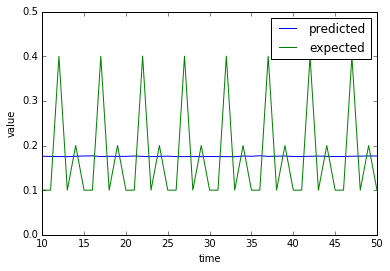

In [17]:
plt.plot(predictions, label='predicted')
plt.plot(data[testStart+1:], label='expected')
plt.xlabel('time')
plt.ylabel('value')
#plt.xlim(-10, len(predictions) + 10)
plt.xlim(10, 50)
plt.ylim(0, 0.5)
plt.legend()

In [ ]:
# Predict with random values as seeds.
len_seed = 1
predictTimeSteps = 200
predicted = np.zeros((batchSize, predictTimeSteps, featurelen))
predicted[:, :len_seed] = np.random.rand(batchSize, 1, featurelen)  #2. * (np.random.rand(batch_size, 1, 3) - 0.5)
model.reset_states()

log_traj = 0
    
# for i in range(len_seed - 1):
# #     print seed[:, i:i+1]
#     model_input = seed[:, i:i+1]
#     model_output = model.predict_on_batch(model_input)[0]
#     print 'Trajectory {}: Input: {} - Output: {}'.format(log_traj, model_input[log_traj], model_output[log_traj])
    
    
# print '------------------------'
    
for i in range(predictTimeSteps - 1):
    model_input = predicted[:, i:i+1]
    model_output = model.predict_on_batch(model_input)[0]    
    #model_output += 0.01 * (np.random.rand(batch_size, 3) - 0.5)
    
    print('Tr {}, step {}: In: {} - Out: {}'.format(log_traj, i, model_input[log_traj], model_output[log_traj]))
    
    if i+1 >= len_seed:
        predicted[:, i+1] = model_output
        print('--> Storing at {}'.format(i+1))
    else:
        print('--> Seed')

In [ ]:
plt.plot(predicted[0], 'b')
#plt.plot(range(len(predictions)), [t[0] for t in targets], 'g')
plt.xlabel('time')
plt.ylabel('value')
plt.xlim(-10, len(predicted[0]) + 10)
plt.ylim(-0.5, 1)
#plt.show()